In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import sklearn.preprocessing as pp

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomascorey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading the csv with themes labeled
pub_data = pd.read_csv("../data/csbc_pson_theme.csv")
pub_data['study.number'] = pub_data['study.number'].replace({"Not Applicable":np.NaN, float('NaN'):np.NaN, 'Core':0, '1':1, '2':2, '3':3}).astype('Int64')
# This csv has the abstracts in it (so I use it to join with the first csv, that's all)
abstracts = pd.read_csv("../data/csbc_pson.csv").loc[:, ["PubMed", "Abstract"]]

In [3]:
# Various pre-processing steps
def remTag(s):
    return re.sub("<[/\w]*>", " ", s)
def remNums(s):
    return re.sub("[\W][\d,.]*[\W]", " ", s)
def remPossessive(s):
    return re.sub("['’`]s\W*", " ", s)
def remPunc(s):
    return re.sub("[-\|?.!;:()_]", " ", s)
def remBSlash(s):
    return re.sub("/", "", s)
def remSWs(s):
    s = s.lower()
    return " ".join([ps.stem(w) for w in s.split() if ps.stem(w) not in stopwords.words('english') and 
                     w not in stopwords.words('english')])

In [4]:
# Left join pub_data with abstracts by the PubMed column
pub_data = pub_data.merge(abstracts, how='left', on='PubMed').\
drop("Abstract_x", axis=1).\
rename({"Abstract_y":"Abstract"}, axis=1)

In [5]:
# Apply those preprocessing steps
ps = PorterStemmer()
pub_data['sim_text'] = pub_data['Abstract'].apply(remTag).\
apply(remNums).apply(remPossessive).apply(remPunc).\
apply(remSWs).apply(remBSlash) + \
pub_data['Title'].apply(remTag).apply(remNums).\
apply(remPossessive).apply(remPunc).apply(remSWs).apply(remBSlash)\


In [6]:
# Takes in a comma separated string containing themes for a publication 
# and creates a list of booleans indicating whether or not that theme is present
# (in the same order order as the "themes" parameter)
def hasTheme(themeList, themes=['tumor-immune', 'microenvironment', 
                                'metastasis', 'heterogeneity/evolution', 
                                'drug resistance/sensitivity']):
    if pd.isna(themeList):
        return [None, None, None, None, None]
    # Separate by commas, strip whitespace, and make lowercase
    themeList = [theme.strip().lower() for theme in themeList.split(",")]
    results = []
    if themeList == "not applicable":
        return [False, False, False, False, False]
    for theme in themes:
        if theme in themeList:
            results += [True]
        else:
            results += [False]
    return results

# Apply this function to pub_data's Theme column, and put it into a results data frame,
# where each column is a boolean representing presence of each individual theme
themeBools = pub_data['Theme'].apply(hasTheme)
results = pd.DataFrame(themeBools.values.tolist(), columns=['tumor-immune', 'microenvironment', 
                                                            'metastasis', 'heterogeneity/evolution', 
                                                            'drug resistance/sensitivity'])


In [7]:
# This cell will print confusion tables for one parametrization of the topic model
# and one theme, as well as precision, recall, f1score, and support(?).
# Unfortunately the confusion tables the transpose of the ones in the slide I sent
# so they go:
# TP, FN
# FP, TN
# I believe. But you can confirm by summing y_train or y_test and seeing what column
# or row that total corresponds to.
# One can change the parameters in the functions and the theme to get different ones
tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
terms_mat = tf.fit_transform(pub_data['sim_text'])
lsa = TruncatedSVD(n_components=20, algorithm="arpack")

topics_mat = lsa.fit_transform(terms_mat.toarray())

theme = 'tumor-immune'
mask = ~pd.isna(results[theme])
topics_masked = topics_mat[~pd.isna(results[theme]),:]
results_masked = results[theme][~pd.isna(results[theme])].apply(int)
X_train, X_test, y_train, y_test = train_test_split(topics_masked, 
                                                    results_masked, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=results_masked)
# Using balanced as the class weight gives the two classes even weight, even though the
# True class is much smaller in all of these cases, so we are emphasizing the True class/
# maximizing recall.
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train, y_train)

# TN, FP
# FN, TP

print(metrics.confusion_matrix(y_train, svc.predict(X_train), labels=(1, 0)))

print(metrics.confusion_matrix(y_test, svc.predict(X_test), labels=(1, 0)))

print(metrics.precision_recall_fscore_support(y_test, svc.predict(X_test), average='binary'))

[[ 20   2]
 [ 12 262]]
[[  9   1]
 [  4 113]]
(0.6923076923076923, 0.9, 0.7826086956521738, None)


In [8]:
# This is the same as the cell above but performs 5 fold cross validation
# and prints the average confusion table at the end

theme = 'tumor-immune'
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

results_masked = results[theme][~pd.isna(results[theme])].apply(int)

x_text = pub_data.loc[~pd.isna(results[theme]), 'sim_text'].reset_index(drop=True)
res = results_masked.reset_index(drop=True)
conf_table = np.zeros((2,2))
for train_index, test_index in skf.split(x_text, results_masked):
    X_train, X_test = x_text[train_index], x_text[test_index]
    y_train, y_test = res[train_index], res[test_index]
    tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
    terms_mat = tf.fit_transform(X_train)
    lsa = TruncatedSVD(n_components=20, algorithm="arpack")
    topics_mat = lsa.fit_transform(terms_mat.toarray())
    svc = LinearSVC(class_weight='balanced')
    svc.fit(topics_mat, y_train)
    print(metrics.confusion_matrix(y_train, svc.predict(lsa.transform(tf.transform(X_train))), labels=(1, 0)))
    print(metrics.confusion_matrix(y_test, svc.predict(lsa.transform(tf.transform(X_test))), labels=(1, 0)))
    conf_table += metrics.confusion_matrix(y_test, svc.predict(lsa.transform(tf.transform(X_test))), labels=(1, 0))
    print(metrics.precision_recall_fscore_support(y_test, svc.predict(lsa.transform(tf.transform(X_test))), average='binary'))
    
print(conf_table/5)

[[ 23   2]
 [ 10 302]]
[[ 6  1]
 [ 3 76]]
(0.6666666666666666, 0.8571428571428571, 0.75, None)
[[ 23   2]
 [ 16 297]]
[[ 7  0]
 [ 1 77]]
(0.875, 1.0, 0.9333333333333333, None)
[[ 24   2]
 [  8 305]]
[[ 5  1]
 [ 3 75]]
(0.625, 0.8333333333333334, 0.7142857142857143, None)
[[ 25   1]
 [ 12 301]]
[[ 5  1]
 [ 2 76]]
(0.7142857142857143, 0.8333333333333334, 0.7692307692307692, None)
[[ 23   3]
 [ 13 300]]
[[ 6  0]
 [ 2 76]]
(0.75, 1.0, 0.8571428571428571, None)
[[ 5.8  0.6]
 [ 2.2 76. ]]


In [9]:
# This is where I make the large confusion table. It's kind of silliness, but
# I basically just create one topic model and reuse it for all 5 themes 
# (since X_train should not change) from theme to theme, but the y's will
# and then train and predict on each new theme. The ___pred object at the end of each
# little chunk is the predictions for that theme. 
# then 
no_nulls = pd.isna(results).agg(sum, axis=1) == 0
agg_results = results.astype(str).agg("-".join, axis=1)[no_nulls].reset_index(drop=True)
x_text = pub_data.loc[no_nulls, 'sim_text'].reset_index(drop=True)



skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
conf_table = np.zeros((len(sorted(agg_results.unique())), len(sorted(agg_results.unique()))))
for train_index, test_index in skf.split(x_text, results_masked):
    theme = 'tumor-immune'
    results_masked = results[theme][no_nulls].apply(int)
    res = results_masked.reset_index(drop=True)
    X_train, X_test = x_text[train_index], x_text[test_index]
    y_train, y_test = res[train_index], res[test_index]
    tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
    terms_mat = tf.fit_transform(X_train)
    lsa = TruncatedSVD(n_components=20, algorithm="arpack")
    topics_mat = lsa.fit_transform(terms_mat.toarray())
    svc = LinearSVC(class_weight='balanced')
    svc.fit(topics_mat, y_train)
    tim_pred = svc.predict(lsa.transform(tf.transform(X_test)))
    # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
    tim_f = metrics.precision_recall_fscore_support(y_test, tim_pred, beta=2, average='binary')[2]
    
    theme = 'microenvironment'
    results_masked = results[theme][no_nulls].apply(int)
    res = results_masked.reset_index(drop=True)
    y_train, y_test = res[train_index], res[test_index]
    svc = LinearSVC(class_weight='balanced')
    svc.fit(topics_mat, y_train)
    mic_pred = svc.predict(lsa.transform(tf.transform(X_test)))
    # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
    mic_f = metrics.precision_recall_fscore_support(y_test, mic_pred, beta=2, average='binary')[2]
    
    
    theme = 'metastasis'
    results_masked = results[theme][no_nulls].apply(int)
    res = results_masked.reset_index(drop=True)
    y_train, y_test = res[train_index], res[test_index]
    svc = LinearSVC(class_weight='balanced')
    svc.fit(topics_mat, y_train)
    met_pred = svc.predict(lsa.transform(tf.transform(X_test)))
    # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
    met_f = metrics.precision_recall_fscore_support(y_test, met_pred, beta=2, average='binary')[2]
    
    theme = 'heterogeneity/evolution'
    results_masked = results[theme][no_nulls].apply(int)
    res = results_masked.reset_index(drop=True)
    y_train, y_test = res[train_index], res[test_index]
    svc = LinearSVC(class_weight='balanced')
    svc.fit(topics_mat, y_train)
    het_pred = svc.predict(lsa.transform(tf.transform(X_test)))
    # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
    het_f = metrics.precision_recall_fscore_support(y_test, het_pred, beta=2, average='binary')[2]
    
    theme = 'drug resistance/sensitivity'
    results_masked = results[theme][no_nulls].apply(int)
    res = results_masked.reset_index(drop=True)
    y_train, y_test = res[train_index], res[test_index]
    svc = LinearSVC(class_weight='balanced')
    svc.fit(topics_mat, y_train)
    drug_pred = svc.predict(lsa.transform(tf.transform(X_test)))
    # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
    drug_f = metrics.precision_recall_fscore_support(y_test, drug_pred, beta=2, average='binary')[2]
    
    fs = [tim_f, mic_f, met_f, het_f, drug_f]
    print(fs)
    print(np.mean(fs))
    
    theme_preds = pd.DataFrame({'tim':tim_pred, 'mic':mic_pred, 'met':met_pred, 'het':het_pred, 'drug':drug_pred}).astype(bool).astype(str).agg("-".join, axis=1)

    conf_table += metrics.confusion_matrix(agg_results[test_index], theme_preds, labels=sorted(agg_results.unique()))
    

[0.8108108108108107, 0.5940594059405941, 0.7236842105263157, 0.5128205128205128, 0.6521739130434783]
0.6587097706283422
[0.9722222222222222, 0.7352941176470589, 0.6451612903225807, 0.6989247311827956, 0.6578947368421053]
0.7418994196433526
[0.78125, 0.08196721311475409, 0.7142857142857143, 0.5833333333333333, 0.7407407407407408]
0.5803154002949085
[0.8064516129032258, 0.7216494845360824, 0.6122448979591836, 0.5494505494505495, 0.7594936708860761]
0.6898580431470234
[0.9375, 0.7051282051282051, 0.7065217391304348, 0.5454545454545455, 0.6557377049180327]
0.7100684389262436


In [10]:
# These two lines are an ENORMOUS mess. They basically take the boolean predictions/truth values
# for each theme and translate them into strings representing all of the themes present.
join_names = lambda x: ", ".\
join([y[1] for y in zip([z == 'True' for z in x.split("-")],\
                        ['tumor-immune', 'microenv', 'metastasis', 'hetero', 'drug']) \
      if y[0]])

# These results are then saved as a large csv confusion table for every possible seen combination of themes
pd.DataFrame(conf_table/5, columns=["pred " + join_names(x) for x in sorted(agg_results.unique())], index=["cond " + join_names(x) for x in sorted(agg_results.unique())]).to_csv("../output/confusiontable.csv", index=True)

In [11]:
## Optimizing over different parameters for tfidf and lsa.
# there's almost certainly nicer ways to do this, but I didn't 
# have time to rewrite all the code about finding the performance over 
# all 5 topics.
n_comps = [x for x in range(10, 50, 5)]
max_dfs = np.linspace(.1,1,10)
ngram_maxs = [1, 2]
hyperparameters = [(x, y, z) for x in n_comps for y in max_dfs for z in ngram_maxs]
mean_fscores = []
for (n_comp, max_df, ngram_max) in hyperparameters:
    print("Hyperparameters: ")
    print(n_comp, max_df, ngram_max)
    # Do the whole k folds for all of the topics. Some of this code probably
    # doesn't need to be in the for loop, but I didn't optimize it much
    no_nulls = pd.isna(results).agg(sum, axis=1) == 0
    agg_results = results.astype(str).agg("-".join, axis=1)[no_nulls].reset_index(drop=True)
    x_text = pub_data.loc[no_nulls, 'sim_text'].reset_index(drop=True)
    
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    conf_table = np.zeros((len(sorted(agg_results.unique())), len(sorted(agg_results.unique()))))
    # Contains all f scores (per theme and fold) for a parametrization
    all_fs = []
    for train_index, test_index in skf.split(x_text, results_masked):
        theme = 'tumor-immune'
        results_masked = results[theme][no_nulls].apply(int)
        res = results_masked.reset_index(drop=True)
        X_train, X_test = x_text[train_index], x_text[test_index]
        y_train, y_test = res[train_index], res[test_index]
        tf = TfidfVectorizer(max_features=10000, max_df = max_df, ngram_range=(1, ngram_max))
        terms_mat = tf.fit_transform(X_train)
        lsa = TruncatedSVD(n_components=n_comp, algorithm="arpack")
        topics_mat = lsa.fit_transform(terms_mat.toarray())
        svc = LinearSVC(class_weight='balanced')
        svc.fit(topics_mat, y_train)
        tim_pred = svc.predict(lsa.transform(tf.transform(X_test)))
        # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
        tim_f = metrics.precision_recall_fscore_support(y_test, tim_pred, beta=2, average='binary')[2]
        
        theme = 'microenvironment'
        results_masked = results[theme][no_nulls].apply(int)
        res = results_masked.reset_index(drop=True)
        y_train, y_test = res[train_index], res[test_index]
        svc = LinearSVC(class_weight='balanced')
        svc.fit(topics_mat, y_train)
        mic_pred = svc.predict(lsa.transform(tf.transform(X_test)))
        # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
        mic_f = metrics.precision_recall_fscore_support(y_test, mic_pred, beta=2, average='binary')[2]
        
        
        theme = 'metastasis'
        results_masked = results[theme][no_nulls].apply(int)
        res = results_masked.reset_index(drop=True)
        y_train, y_test = res[train_index], res[test_index]
        svc = LinearSVC(class_weight='balanced')
        svc.fit(topics_mat, y_train)
        met_pred = svc.predict(lsa.transform(tf.transform(X_test)))
        # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
        met_f = metrics.precision_recall_fscore_support(y_test, met_pred, beta=2, average='binary')[2]
        
        theme = 'heterogeneity/evolution'
        results_masked = results[theme][no_nulls].apply(int)
        res = results_masked.reset_index(drop=True)
        y_train, y_test = res[train_index], res[test_index]
        svc = LinearSVC(class_weight='balanced')
        svc.fit(topics_mat, y_train)
        het_pred = svc.predict(lsa.transform(tf.transform(X_test)))
        # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
        het_f = metrics.precision_recall_fscore_support(y_test, het_pred, beta=2, average='binary')[2]
        
        theme = 'drug resistance/sensitivity'
        results_masked = results[theme][no_nulls].apply(int)
        res = results_masked.reset_index(drop=True)
        y_train, y_test = res[train_index], res[test_index]
        svc = LinearSVC(class_weight='balanced')
        svc.fit(topics_mat, y_train)
        drug_pred = svc.predict(lsa.transform(tf.transform(X_test)))
        # weighted f-score (f-beta score weights recall more than precision by a factor of beta)
        drug_f = metrics.precision_recall_fscore_support(y_test, drug_pred, beta=2, average='binary')[2]
        
        fs = [tim_f, mic_f, met_f, het_f, drug_f]
        all_fs += fs
    mean_fscores += [np.mean(all_fs)]
    print("Mean F Score")
    print(np.mean(all_fs))


Hyperparameters: 
10 0.1 1
Mean F Score
0.55424168976098
Hyperparameters: 
10 0.1 2
Mean F Score
0.5849125470001743
Hyperparameters: 
10 0.2 1
Mean F Score
0.6341268629996876
Hyperparameters: 
10 0.2 2
Mean F Score
0.6341982568131344
Hyperparameters: 
10 0.30000000000000004 1
Mean F Score
0.6138267721945698
Hyperparameters: 
10 0.30000000000000004 2
Mean F Score
0.6132761532091088
Hyperparameters: 
10 0.4 1
Mean F Score
0.6163324513915793
Hyperparameters: 
10 0.4 2
Mean F Score
0.6068437100076685
Hyperparameters: 
10 0.5 1
Mean F Score
0.614342833410549
Hyperparameters: 
10 0.5 2
Mean F Score
0.602750231493482
Hyperparameters: 
10 0.6 1
Mean F Score
0.6056211859231238
Hyperparameters: 
10 0.6 2
Mean F Score
0.6001794303025669
Hyperparameters: 
10 0.7000000000000001 1
Mean F Score
0.6152640157016431
Hyperparameters: 
10 0.7000000000000001 2
Mean F Score
0.6015084936301455
Hyperparameters: 
10 0.8 1
Mean F Score
0.6152640157016431
Hyperparameters: 
10 0.8 2
Mean F Score
0.601508493630145

Mean F Score
0.6391943731215215
Hyperparameters: 
40 0.7000000000000001 2
Mean F Score
0.6443664659881461
Hyperparameters: 
40 0.8 1
Mean F Score
0.6391943731215215
Hyperparameters: 
40 0.8 2
Mean F Score
0.6443664659881461
Hyperparameters: 
40 0.9 1
Mean F Score
0.6391943731215215
Hyperparameters: 
40 0.9 2
Mean F Score
0.6443664659881461
Hyperparameters: 
40 1.0 1
Mean F Score
0.6391943731215215
Hyperparameters: 
40 1.0 2
Mean F Score
0.6443664659881461
Hyperparameters: 
45 0.1 1
Mean F Score
0.564445287181032
Hyperparameters: 
45 0.1 2
Mean F Score
0.5623978045252316
Hyperparameters: 
45 0.2 1
Mean F Score
0.6517283689015534
Hyperparameters: 
45 0.2 2
Mean F Score
0.6468043087813384
Hyperparameters: 
45 0.30000000000000004 1
Mean F Score
0.6497622883009951
Hyperparameters: 
45 0.30000000000000004 2
Mean F Score
0.6475543323489424
Hyperparameters: 
45 0.4 1
Mean F Score
0.6283163499568001
Hyperparameters: 
45 0.4 2
Mean F Score
0.6414042499222852
Hyperparameters: 
45 0.5 1
Mean F Sco

Top 10 mean fscores
[0.67314504 0.67116824 0.66612694 0.66574352 0.66496895 0.66351698
 0.65745764 0.65544251 0.65544251 0.65544251]
Hyperparameters of the top 10 mean fscores
[(15, 0.4, 2), (15, 0.5, 2), (20, 0.2, 1), (20, 0.2, 2), (15, 0.6, 2), (25, 0.30000000000000004, 1), (35, 0.30000000000000004, 2), (25, 1.0, 2), (25, 0.7000000000000001, 2), (25, 0.8, 2)]
Histogram of fscores


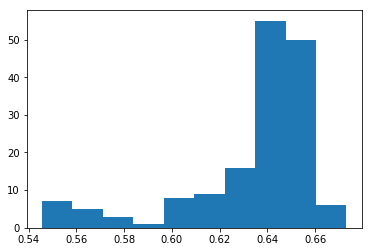

In [12]:
print("Top 10 mean fscores")
print(np.sort(mean_fscores)[:-11:-1])
print("Hyperparameters of the top 10 mean fscores")
print([hyperparameters[i] for i in list(np.argsort(mean_fscores)[:-11:-1])])
print("Histogram of fscores")
plt.hist(mean_fscores)
plt.show()

In [13]:
# This code re-makes the topic model and then attempts to find the highest and lowest
# correlated topics with the theme of choice. This is just for investigation, never really used these results

theme = 'tumor-immune'
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

results_masked = results[theme][~pd.isna(results[theme])].apply(int)

x_text = pub_data.loc[~pd.isna(results[theme]), 'sim_text'].reset_index(drop=True)
res = results_masked.reset_index(drop=True)

for train_index, test_index in skf.split(x_text, results_masked):
    X_train, X_test = x_text[train_index], x_text[test_index]
    y_train, y_test = res[train_index], res[test_index]
    tf = TfidfVectorizer(max_features=10000, max_df = .7, ngram_range=(1,2))
    terms_mat = tf.fit_transform(X_train)

topic_cors = np.corrcoef(topics_masked, np.reshape(np.array(results_masked), (-1, 1)), rowvar=False)[-1, :-1]

# Getting term indices from topics and words from those indices
ranked_ids = np.argsort(lsa.components_)
term_by_index = {v: k for k, v in tf.vocabulary_.items()}

f = lambda ID: term_by_index[ID]
vf = np.vectorize(f)

ranked_terms = vf(ranked_ids)
print("Most positively correlated topics")
print(ranked_terms[np.argsort(topic_cors)[:-4:-1], :-11:-1])
print("Most negatively correlated topics")
print(ranked_terms[np.argsort(-1*topic_cors)[:-4:-1], :-11:-1])

Most positively correlated topics
[['discret' 'p447 l455' 'noncod molecular' 'mutat chronic' 'doubl strand'
  'addit model' 'multiplex combinatori' 'tumor glioblastoma' 'p53 activ'
  'downregul']
 ['brillouin' 'black' 'core residu' 'target cancer' 'gene regulatori'
  'gene howev' 'inhibit troy' 'screen patient' 'gene interact'
  'observ use']
 ['catalyt activ' 'brillouin' 'tumor glioblastoma' 'million'
  'mani target' 'bodi mass' 'gene regulatori' 'gal4' 'prompt'
  'mutat chronic']]
Most negatively correlated topics
[['chemic physic' 'character tumor' 'gene regulatori' '2d'
  'collagen type' 'osteogenesi stiff' 'light illumin' 'trade'
  'clonal expans' 'akti']
 ['bodi mass' 'bone' 'work show' 'normal diseas' 'discret' 'enzym' 'inde'
  'rna' 'prompt' 'equat']
 ['prompt' 'drug dose' 'tumor glioblastoma' 'macrophag ctl'
  'studi includ' 'ic' 'noncod molecular' 'flfl' 'healthi' 'analys']]


In [14]:
# Making topic model again, and just looking at the top words in the topics
tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
terms_mat = tf.fit_transform(pub_data['sim_text'])
lsa = TruncatedSVD(n_components=30, algorithm="arpack")

topics_mat = lsa.fit_transform(terms_mat.toarray())

ranked_ids = np.argsort(lsa.components_)
term_by_index = {v: k for k, v in tf.vocabulary_.items()}

f = lambda ID: term_by_index[ID]
vf = np.vectorize(f)

ranked_terms = vf(ranked_ids)
print(ranked_terms[:5, :-10:-1])
print(ranked_terms[5:10, :-10:-1])
print(ranked_terms[10:15, :-10:-1])
print(ranked_terms[15:20, :-10:-1])
print(ranked_terms[20:25, :-10:-1])
print(ranked_terms[25:30, :-10:-1])

[['cell' 'cancer' 'tumor' 'breast' 'model' 'mechan' 'breast cancer'
  'tissu' 'drug']
 ['breast' 'breast cancer' 'women' 'cancer' 'risk' 'african' 'er'
  'american' 'african american']
 ['cell' 'matrix' 'stiff' 'migrat' 'mechan' 'breast' 'ecm' 'collagen'
  'nuclear']
 ['dna' 'chromatin' 'protein' 'network' 'gene' 'nuclear' 'genom'
  'chromosom' 'transcript']
 ['cell' 'singl cell' 'rna' 'singl' 'seq' 'network' 'cell rna' 'gene'
  'analysi']]
[['obes' 'bet' 'inflamm' 'regul' 'diabet' 'immun' 'cytokin' 'metabol'
  'protein']
 ['dna' 'tumor' 'genom' 'express' 'mutat' 'methyl' 'gene' 'nuclear'
  'cancer']
 ['network' 'tumor' 'ecm' 'interact' 'pathway' 'matrix' 'protein' 'gene'
  'signal']
 ['obes' 'genom' 'mutat' 'matrix' 'stiff' 'nuclear' 'network' 'diabet'
  'lamin']
 ['nuclear' 'drug' 'resist' 'lamin' 'gene' 'bet' 'nucleu' 'inhibitor'
  'her2']]
[['nuclear' 'immun' 'cancer' 'ruptur' 'nucleu' 'envelop' 'network'
  'membran' 'lamin']
 ['chromosom' 'chromatin' 'condensin' 'loop' 'cancer' 'm

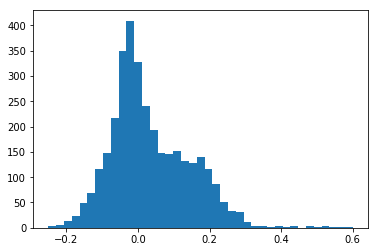

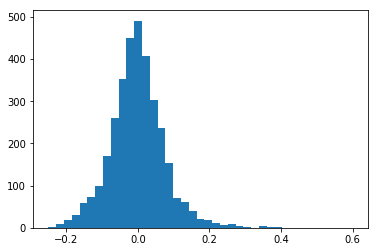

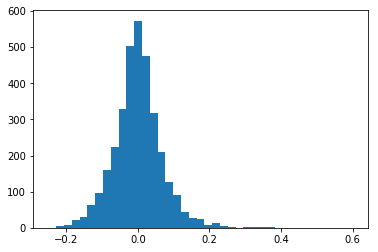

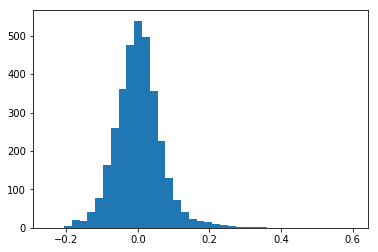

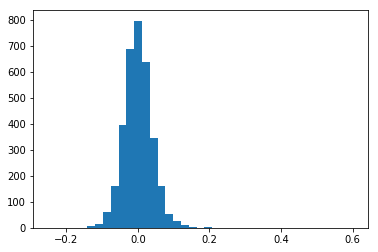

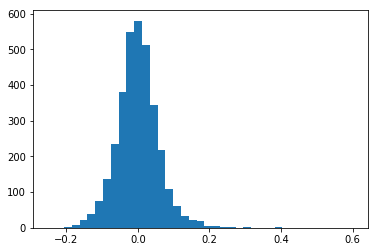

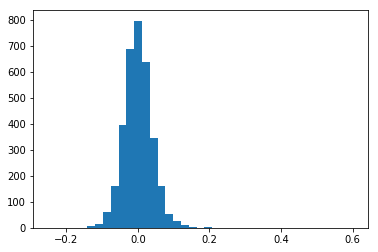

In [15]:
# Printing histograms of topics loading, ideally something like a bimodal distribution
# or at least one with decent spread. Good for learning intuition about how many
# topics to use (eg maybe past 30, they are super tight around zero, indicating
# that the added information from that topic may not be worth the added dimension)
tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
terms_mat = tf.fit_transform(pub_data['sim_text'])
lsa = TruncatedSVD(n_components=200, algorithm="arpack")

topics_mat = lsa.fit_transform(terms_mat.toarray())

bins = np.linspace(-0.25, 0.6, 40)
import matplotlib.pyplot as plt
plt.hist((topics_mat[:, :5]).flatten(), bins=bins)
plt.show()

plt.hist((topics_mat[:, 5:10]).flatten(), bins=bins)
plt.show()

plt.hist((topics_mat[:, 10:15]).flatten(), bins=bins)

plt.show()

plt.hist((topics_mat[:, 15:20]).flatten(), bins=bins)

plt.show()

plt.hist((topics_mat[:, -5:]).flatten(), bins=bins)
plt.show()
plt.hist((topics_mat[:, 25:30]).flatten(), bins=bins)
plt.show()
plt.hist((topics_mat[:, -5:]).flatten(), bins=bins)
plt.show()

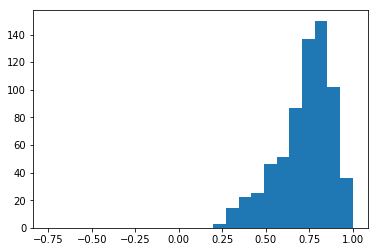

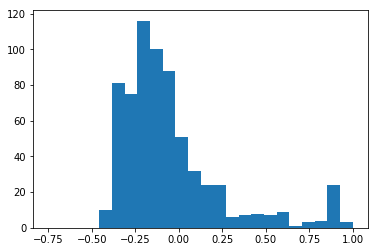

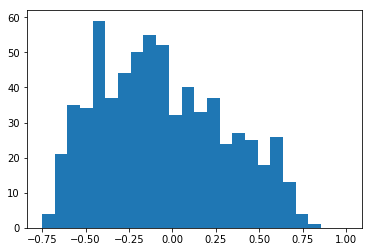

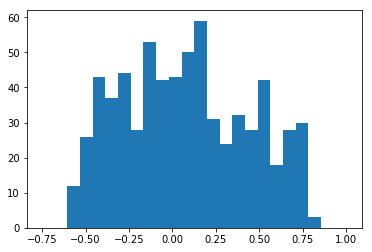

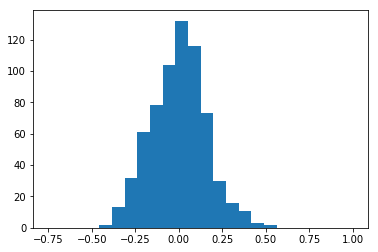

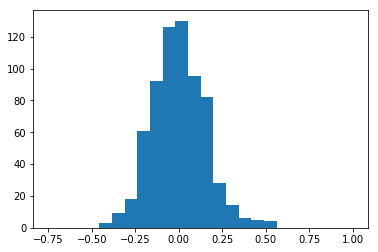

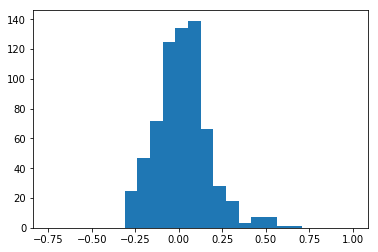

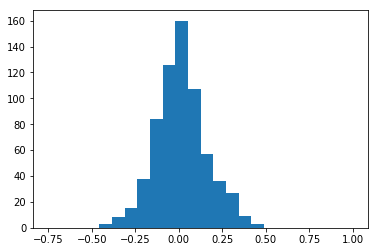

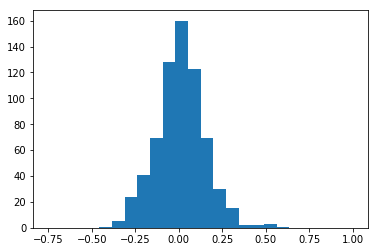

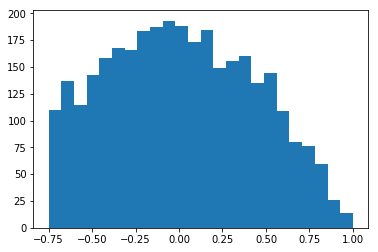

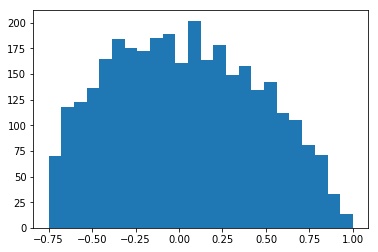

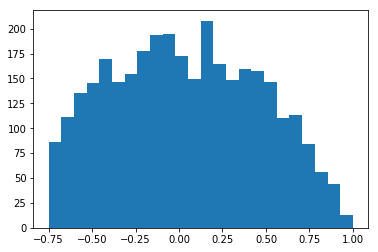

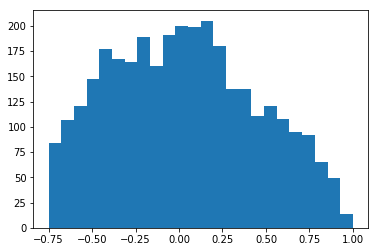

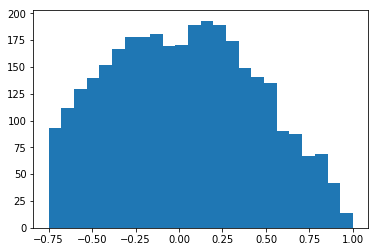

In [16]:
# Same exact thing as above but normalizing. If axis = 1 we are normalizing the scores within each sample
# (publication). If axis = 0, we are normalizing each column of the topics_mat or normalizing within each
# topic. 
tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
terms_mat = tf.fit_transform(pub_data['sim_text'])
lsa = TruncatedSVD(n_components=30, algorithm="arpack")

topics_mat = lsa.fit_transform(terms_mat.toarray())

bins = np.linspace(-0.75, 1, 25)
import matplotlib.pyplot as plt
plt.hist(pp.normalize(topics_mat[:, :5], axis=1)[:,0].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :5], axis=1)[:,1].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :5], axis=1)[:,2].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :5], axis=1)[:,3].flatten(), bins=bins)
plt.show()

plt.hist(pp.normalize(topics_mat[:, :], axis=1)[:,10].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :], axis=1)[:,13].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :], axis=1)[:,16].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :], axis=1)[:,20].flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, :], axis=1)[:,29].flatten(), bins=bins)
plt.show()



plt.hist(pp.normalize(topics_mat[:, 5:10], axis=1).flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, 10:15], axis=1).flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, 15:20], axis=1).flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, 20:25], axis=1).flatten(), bins=bins)
plt.show()
plt.hist(pp.normalize(topics_mat[:, 25:30], axis=1).flatten(), bins=bins)
plt.show()

In [17]:
# Attemping to start working on the strategy of matching publications to projects within their grant 
# and then automatically taggin the publication with that project's assigned themes. 
# This is an unsupervised method
# To turn these cells alone, run the first 5 cells in the notebook first.
# Read data about project descriptions etc
proj_dat = pd.read_csv("../data/projects_and_cores.tsv", sep="\t", 
                       header=None, names=['center', 'porc', 'number', 'title', 'desc'])

## Might need new preprocessing for this... 
proj_dat['sim_desc'] = proj_dat['desc'].apply(remTag).\
apply(remNums).apply(remPossessive).apply(remPunc).\
apply(remSWs).apply(remBSlash)

# Type conversion to join the datasets. Hopefully this works. Requires pandas >= 0.24 I'm pretty sure
# because < doesn't allow nullable int types? 
proj_dat['number'] = proj_dat['number'].astype('Int64')
pub_data['centerName'] = pub_data['centerName'].astype(str)
proj_dat['center'] = proj_dat['center'].astype(str)
# Have to ignore core for now, it's my last day, haha. Causing trouble with the join (merge)
proj_dat = proj_dat[proj_dat['porc'] == 'Project']
pub_data = pub_data.merge(proj_dat, how='inner', left_on=['centerName', 'study.number'], right_on=['center', 'number'])


In [20]:
# Iterate through all the publications and try to see how well we can guess their project
tf = TfidfVectorizer(max_features=10000, max_df = 0.7, ngram_range=(1,2))
terms_mat = tf.fit_transform(pub_data['sim_text'])
lsa = TruncatedSVD(n_components=30, algorithm="arpack")
topics_mat = lsa.fit_transform(terms_mat.toarray())


correct = 0
proj_per_grant = 0
num_with_one = 0
for row_num, row in pub_data.iterrows():
    print("Row: " + str(row_num))
    print("Publication title: " + row['Title'])
    # Filter for projects in this publication's grant
    projs = proj_dat.loc[proj_dat['center'] == row['centerName']]
    if len(projs) == 1:
        print("Only 1 project in this grant")
        num_with_one += 1
        continue
    proj_per_grant += len(projs)
    # Transform project description into topics
    proj_terms = tf.transform(projs['sim_desc'])
    proj_topics = lsa.transform(proj_terms)
    sims = np.dot(proj_topics, topics_mat[row_num, :].T)/(np.linalg.norm(proj_topics)*np.linalg.norm(topics_mat[row_num, :].T))
    print("Similarity scores: ")
    print(sims)
    print("Correct project number: ")
    print(row['study.number'])
    print("Most 'similar' project description: ")
    print(projs.iloc[np.argmax(sims),:].number)
    print("Correct project title: ")
    print(row['title'])
    print("Title of most 'similar' project description: ")
    print(projs.iloc[np.argmax(sims),:].title)
    if projs.iloc[np.argmax(sims),:].number == row['study.number']:
        correct += 1
    print("Running accuracy: " + str(correct/(row_num + 1)))
        
print("Accuracy: " + str(correct/(row_num + 1)))
print("Number of publications with only one project possibility: " + str(num_with_one))
print("Average number of projects per publication with more than one: " + str(proj_per_grant/(row_num + 1 - num_with_one)))

Row: 0
Publication title: Combating subclonal evolution of resistant cancer phenotypes
Similarity scores: 
[0.66443464 0.44260686]
Correct project number: 
1
Most 'similar' project description: 
1
Correct project title: 
Dynamic genomic and microenvironmental models of chemoresistance
Title of most 'similar' project description: 
Dynamic genomic and microenvironmental models of chemoresistance
Running accuracy: 1.0
Row: 1
Publication title: Mechanisms and clinical implications of tumor heterogeneity and convergence on recurrent phenotypes
Similarity scores: 
[0.5332098  0.55666477]
Correct project number: 
1
Most 'similar' project description: 
2
Correct project title: 
Dynamic genomic and microenvironmental models of chemoresistance
Title of most 'similar' project description: 
Targeting cooperative phenotypes common in spatial heterogeneity
Running accuracy: 0.5
Row: 2
Publication title: Activity of distinct growth factor receptor network components in breast tumors uncovers two biol

Similarity scores: 
[0.03903521 0.11233651 0.08160114]
Correct project number: 
1
Most 'similar' project description: 
2
Correct project title: 
Effects of the Physical Microenvironment on Metabolism
Title of most 'similar' project description: 
Metabolism-Mediated Changes of Microvesicle Biogenesis
Running accuracy: 0.26666666666666666
Row: 30
Publication title: Metabolic Obesity, Adipose Inflammation and Elevated Breast Aromatase in Women with Normal Body Mass Index
Similarity scores: 
[0.24064433 0.08521482 0.09882678]
Correct project number: 
1
Most 'similar' project description: 
1
Correct project title: 
Effects of the Physical Microenvironment on Metabolism
Title of most 'similar' project description: 
Effects of the Physical Microenvironment on Metabolism
Running accuracy: 0.2903225806451613
Row: 31
Publication title: Adiposity, Inflammation and Breast Cancer Pathogenesis in Asian Women
Similarity scores: 
[0.25647725 0.10786407 0.12091505]
Correct project number: 
1
Most 'simi

Similarity scores: 
[0.16108349 0.17774539 0.17565913]
Correct project number: 
3
Most 'similar' project description: 
2
Correct project title: 
Physical and Metabolic Constraints of Cancer Cell Invasion
Title of most 'similar' project description: 
Metabolism-Mediated Changes of Microvesicle Biogenesis
Running accuracy: 0.45588235294117646
Row: 68
Publication title: Breast cancer-derived extracellular vesicles stimulate myofibroblast differentiation and pro-angiogenic behavior of adipose stem cells
Similarity scores: 
[0.37202917 0.36906902 0.32830856]
Correct project number: 
2
Most 'similar' project description: 
1
Correct project title: 
Metabolism-Mediated Changes of Microvesicle Biogenesis
Title of most 'similar' project description: 
Effects of the Physical Microenvironment on Metabolism
Running accuracy: 0.4492753623188406
Row: 69
Publication title: Characterization of the interactions of potent allosteric inhibitors with glutaminase C, a key enzyme in cancer cell glutamine met

Similarity scores: 
[0.45944588 0.47635888 0.23481255]
Correct project number: 
3
Most 'similar' project description: 
2
Correct project title: 
nan
Title of most 'similar' project description: 
Molecular modulation of chromatin and nuclear structure in cancer
Running accuracy: 0.34951456310679613
Row: 103
Publication title: Single-Molecule Magnetic Tweezer Analysis of Topoisomerases
Similarity scores: 
[0.14827773 0.13627005 0.04990645]
Correct project number: 
3
Most 'similar' project description: 
1
Correct project title: 
nan
Title of most 'similar' project description: 
Ionic modulation of chromatin in cancer
Running accuracy: 0.34615384615384615
Row: 104
Publication title: Bend-Induced Twist Waves and the Structure of Nucleosomal DNA
Similarity scores: 
[0.14432519 0.16156393 0.03920787]
Correct project number: 
3
Most 'similar' project description: 
2
Correct project title: 
nan
Title of most 'similar' project description: 
Molecular modulation of chromatin and nuclear structure

Similarity scores: 
[0.1182945  0.12927774 0.27173752]
Correct project number: 
3
Most 'similar' project description: 
3
Correct project title: 
Predicting therapeutic sensitivity in cancer. 
Title of most 'similar' project description: 
Predicting therapeutic sensitivity in cancer. 
Running accuracy: 0.38028169014084506
Row: 142
Publication title: Spatiotemporal genomic architecture informs precision oncology in glioblastoma
Similarity scores: 
[0.22609263 0.47507984 0.51121163]
Correct project number: 
3
Most 'similar' project description: 
3
Correct project title: 
Predicting therapeutic sensitivity in cancer. 
Title of most 'similar' project description: 
Predicting therapeutic sensitivity in cancer. 
Running accuracy: 0.38461538461538464
Row: 143
Publication title: Regulatory T Cells Exhibit Distinct Features in Human Breast Cancer
Similarity scores: 
[0.39734818 0.41261626 0.3722408 ]
Correct project number: 
1
Most 'similar' project description: 
2
Correct project title: 
Tumor-

Publication title: Modeling Physiological Events in 2D vs 3D Cell Culture
Only 1 project in this grant
Row: 281
Publication title: Cell volume change through water efflux impacts cell stiffness and stem cell fate
Only 1 project in this grant
Row: 282
Publication title: Long-lived force patterns and deformation waves at repulsive epithelial boundaries
Only 1 project in this grant
Row: 283
Publication title: Hidden in the mist no more: physical force in cell biology
Only 1 project in this grant
Row: 284
Publication title: Cellular Contraction and Polarization Drive Collective Cellular Motion
Only 1 project in this grant
Row: 285
Publication title: Evaluation of CAIX and CAXII Expression in Breast Cancer at Varied O2 Levels: CAIX is the Superior Surrogate Imaging Biomarker of Tumor Hypoxia
Similarity scores: 
[0.37427641 0.29896182]
Correct project number: 
1
Most 'similar' project description: 
1
Correct project title: 
nan
Title of most 'similar' project description: 
nan
Running accura

Similarity scores: 
[0.         0.         0.07252063]
Correct project number: 
3
Most 'similar' project description: 
3
Correct project title: 
Liver cancer nuclear rheology 
Title of most 'similar' project description: 
Liver cancer nuclear rheology 
Running accuracy: 0.24411764705882352
Row: 340
Publication title: Genome variation across cancers scales with tissue stiffness - an invasion-mutation mechanism and implications for immune cell infiltration
Similarity scores: 
[ 0.          0.         -0.03201424]
Correct project number: 
3
Most 'similar' project description: 
1
Correct project title: 
Liver cancer nuclear rheology 
Title of most 'similar' project description: 
Liver cancer pre-malignant stiffening 
Running accuracy: 0.2434017595307918
Row: 341
Publication title: Myosin-II repression favors pre/proplatelets but shear activation generates platelets and fails in macrothrombocytopenia
Similarity scores: 
[0.         0.         0.12319423]
Correct project number: 
3
Most 'sim

Similarity scores: 
[0.40535232 0.33499209 0.29620631]
Correct project number: 
1
Most 'similar' project description: 
1
Correct project title: 
Murine modeling of tumor-mediated immunosuppression
Title of most 'similar' project description: 
Murine modeling of tumor-mediated immunosuppression
Running accuracy: 0.2462686567164179
Row: 402
Publication title: Deep Profiling of Mouse Splenic Architecture with CODEX Multiplexed Imaging
Similarity scores: 
[0.29213228 0.29667785 0.34797041]
Correct project number: 
2
Most 'similar' project description: 
3
Correct project title: 
Spatial architecture of tumor-mediated immunosuppression
Title of most 'similar' project description: 
Integrative computational modeling of tumor-mediated immunosuppression
Running accuracy: 0.2456575682382134
Row: 403
Publication title: START: a system for flexible analysis of hundreds of genomic signal tracks in few lines of SQL-like queries
Similarity scores: 
[0.14102961 0.21192608 0.25222486]
Correct project n